In [1]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Initialising the CNN
classifier = Sequential()

In [3]:
# Step1 - Convolution
classifier.add(Convolution2D(64, 3, 3, input_shape = (64, 64, 3), activation = 'relu'))

In [4]:
# Step2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2,2)))

In [5]:
# Adding a second convolution layer
classifier.add(Convolution2D(64, 3, 3, activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2,2)))

In [6]:
# step3 - Flattening
classifier.add(Flatten())

In [8]:
# Step4 - Full COnnection
classifier.add(Dense(units= 128, activation = 'relu'))
classifier.add(Dense(units= 1, activation = 'sigmoid'))

In [9]:
# Compiling the CNN
classifier.compile(optimizer ='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
training_set = train_datagen.flow_from_directory(
        'Malaria Cells/training_set',
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary')

test_set = test_datagen.flow_from_directory(
        'Malaria Cells/testing_set',
        target_size=(64, 64),
        batch_size=32,
        class_mode='binary')

Found 27558 images belonging to 2 classes.
Found 15832 images belonging to 2 classes.


### Early Stopping

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

In [14]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [22]:
# nb_epochs how much times you want to back propogate
# steps_per_epoch it will transfer that many images at 1 time
# & epochs means 'steps_per_epoch' will repeat that many times
classifier.fit(
        training_set,
        steps_per_epoch=100,
        epochs=5,
        validation_data=test_set,
        validation_steps=50,
        callbacks=[early_stop])

Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 50s 475ms/step - accuracy: 0.6390 - loss: 0.6416 - val_accuracy: 0.7200 - val_loss: 0.5743
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 416ms/step - accuracy: 0.6807 - loss: 0.5957 - val_accuracy: 0.7419 - val_loss: 0.5537
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 354ms/step - accuracy: 0.7026 - loss: 0.5907 - val_accuracy: 0.7487 - val_loss: 0.5393
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 307ms/step - accuracy: 0.7110 - loss: 0.5718 - val_accuracy: 0.7394 - val_loss: 0.5368
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 274ms/step - accuracy: 0.7103 - loss: 0.5652 - val_accuracy: 0.7556 - val_loss: 0.5489


### Evaluating the Model

In [23]:
import pandas as pd
losses = pd.DataFrame(classifier.history.history)

<Axes: >

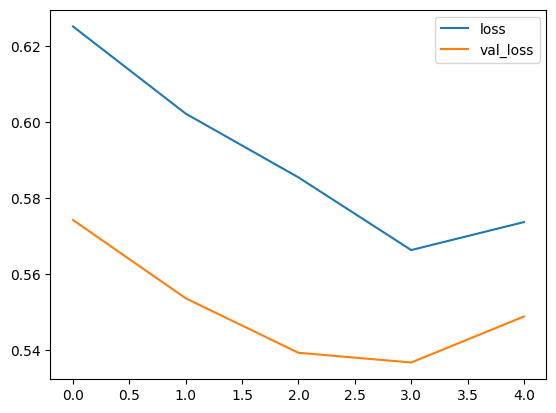

In [24]:
losses[['loss','val_loss']].plot()

In [25]:
classifier.metrics_names

['loss', 'compile_metrics']

In [27]:
classifier.evaluate(test_set, steps=len(test_set))

495/495 ━━━━━━━━━━━━━━━━━━━━ 93s 188ms/step - accuracy: 0.7537 - loss: 0.5546


[0.5536900162696838, 0.7524002194404602]

In [28]:
from tensorflow.keras.preprocessing import image

In [38]:
import numpy as np

test_image = image.load_img(r'Test_Images/Test_Images/Uninfected.png', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)
training_set.class_indices
if result[0][0] == 1:
    prediction = 'Uninfected'
else:
    prediction = 'Parasitised'
prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


'Uninfected'